# Land use and Land Cover Classification

The availability of free satellite data has increased its use in several applications in the domains of agriculture, disaster recovery, climate change, urban development, or environmental monitoring can be realized. However, to fully utilize the data for the previously mentioned domains, first satellite images must be processed and transformed into structured semantics. One type of such fundamental semantics is Land Use and Land Cover Classification. The aim of land use and land cover classification is to automatically provide labels describing the represented physical land type or how a land area is used (e.g., residential, industrial)

A satellite image dataset for the task of land use and land cover classification was presented in [[1]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8519248). The EuroSAT dataset is based on Sentinel-2 satellite images and consists of 27,000 labeled images with a total of 10 different classes listed below where the patches are 64x64 pixels each.

![alt text](./Images/dataset.png "The EuroSAT Dataset")

In this assignment you are going to use the optical bands of Sentinel-2 which are computed by combining the bands red (B04), green (B03) and blue (B02) from the Sentinel-2 product. More information about the Sentinel-2 bands can be found [here](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial). You will then train different Convolutional Neural Network (CNN) models to classify every 64x64 patches in one of the following classes:

1. AnnualCrop
2. Forest
3. Herbaceous Vegetation
4. Highway
5. Industrial
6. Pasture
7. Permanent Crop
8. Residential
9. River
10. SeaLake



## Instructions
The EuroSAT dataset is based on Sentinel-2 satellite images and consists of 27,000 labeled images with a total of 10 different classes. The dataset is structured as follows:
1. `train.txt`: this file contains a list of images that will be used to train the Convolutional Neural Network (CNN) models.
2. `test.txt`: this file contains a list of images that will be used to test the Convolutional Neural Network (CNN) models.
3. A list of 10 folders, each one containing the images pertaining to each class.

All code needs to be developed in Python 3 and run on a Ubuntu 20.04 environment or later versions of Ubuntu. The student is requested send the jupyter notebook using the template provided. Any textual or visual information and equations that the student might need to convey is expected to be written using the markdown language within the same Juputer Notebook. The Juputer Notebook should be named as follows

`name-surname.ipynb`

The list of packages that are allowed for this assignment are: `matplotlib`, `os`, `numpy`, `torch`, `open-cv`, `torchvision` and any other packages agreed with the lecturer.


## Assignment

**Q1:** A lot of effort in solving any machine learning and computer vision problem goes into preparing the data. PyTorch provides a simple mechanism to define a custom dataset using `torch.utils.data.Dataset`, which is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__` so that it initializes the dataset
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get i-th sample.


Write a class `DataLoaderClassification` that can be used to
- load the list of image filenames and the corresponding lables in two lists in `__init__`
- load a batch of images and corresponding lables when one calls `__getitem__`
- returns the length of the dataset using `__len__`

Write the code in one or more cells.

In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


Debug = True # Used to control the prints

In [2]:
####################################################################
#  DataLoaderClassification() ::    Custom         method          #
####################################################################
class DataLoaderClassification(Dataset):
    def __init__(self, data_dir, file_list_path):
        # Args:
        #    data_dir :: Path to the directory containing image subfolders.
        #    file_list_path :: Path to the text file containing image paths (e.g., train.txt or test.txt).

        self.data_dir = data_dir        
        self.image_paths = []
        self.labels = []
        
        # A set to collect unique labels
        label_set = set()
        
        with open(file_list_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    updated_path = line.replace('EuroSAT/', '')  
                    self.image_paths.append(updated_path)
                    
                    label = os.path.split(updated_path)[0].replace('./Data/', '')  
                    self.labels.append(label)
                    label_set.add(label)  # Collect unique labels
                    
        # Create a mapping from label strings to integers
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(label_set))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_full_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = cv2.imread(img_full_path)
        if image is None:
            raise FileNotFoundError(f"Image at path {img_full_path} could not be loaded.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# Convert to RGB

        # image to tensor
        transform = transforms.ToTensor()
        image = transform(image)
        
        # Convert label from string to integer using the label mapping and, then, to tensor
        label = self.label_to_index[label]
        label = torch.tensor(label)
                
        return image, label

**Q2:** Write the code in one cell that uses the list of files included in `train.txt` and `test.txt` to create a Pytorch dataloader for the training and testing data, respectively.

**Loading in batches**

In [3]:

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

data_dir = 'Data'
train_file_list = 'Data/train.txt'
test_file_list = 'Data/test.txt'


train_dataset = DataLoaderClassification(data_dir=data_dir, file_list_path=train_file_list)
test_dataset  = DataLoaderClassification(data_dir=data_dir, file_list_path=test_file_list)

print(f"Number of items in train_dataset: {len(train_dataset)}")
print(f"Number of items in test_dataset: {len(test_dataset)}")


num_workers = 4   # number of subprocesses to use for data loading (for paralelization)
batch_size = 20   # how many samples per batch to load

# split train in validation + train
valid_size = 0.2  # percentage of training set to use as validation

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          sampler=train_sampler, shuffle=False)#, num_workers=num_workers)
valid_loader = DataLoader(train_dataset, batch_size=batch_size,
                          sampler=valid_sampler, shuffle=False)#, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False)#, num_workers=num_workers)



# Testing etitem
if Debug:
    test_index = random.randint(0, 21599)
    print(f"Check item {test_index} from train_dataset")
    image, label = train_dataset[test_index]
    print(f"Image {test_index} -> Shape: {image.shape}, Label: {label}")



######
# print_batches :: Debugger function
#######
def print_batches(loader, batchtype = "", maxshow=1, Debug=False):
    if Debug:
        for batch_idx, (images, labels) in enumerate(loader):
            print(f"\n {batchtype} batch {batch_idx + 1}  \n   Image batch shape: {images.shape}, \n   Labels: {labels}")
            if batch_idx == maxshow:
                break
        print(f"\n{batchtype} data type (images): {images.dtype}, Data type (labels): {labels.dtype}\n")
                
print_batches(train_loader, "Train", Debug=False)
print_batches(test_loader, "Test", Debug=False)

print_batches(train_loader,"Train", Debug=Debug)
print_batches(valid_loader,"Validation", Debug=Debug)
print_batches(test_loader, "Test", Debug=Debug)

Number of items in train_dataset: 21600
Number of items in test_dataset: 5400
Check item 20960 from train_dataset
Image 20960 -> Shape: torch.Size([3, 64, 64]), Label: 0

 Train batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([8, 1, 7, 6, 2, 9, 2, 0, 0, 2, 9, 7, 4, 8, 8, 3, 0, 2, 8, 9])

 Train batch 2  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([6, 2, 5, 4, 2, 1, 6, 1, 7, 8, 2, 3, 2, 3, 7, 2, 3, 9, 0, 7])

Train data type (images): torch.float32, Data type (labels): torch.int64


 Validation batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([9, 7, 6, 7, 6, 7, 4, 1, 6, 8, 6, 6, 1, 0, 0, 2, 9, 1, 2, 7])

 Validation batch 2  
   Image batch shape: torch.Size([20, 3, 64, 64]), 
   Labels: tensor([2, 5, 1, 0, 6, 5, 7, 4, 0, 4, 3, 7, 9, 6, 6, 7, 2, 6, 4, 2])

Validation data type (images): torch.float32, Data type (labels): torch.int64


 Test batch 1  
   Image batch shape: torch.Size([20, 3, 64, 64]

**Q3:** PyTorch provides the elegantly designed modules and classes, including `torch.nn`, to help you create and train neural networks. An `nn.Module` contains layers, and a method `forward(input)` that returns the output. Write the `CNN` class to define a Convolutional Neural Network (CNN) where the first convolutional layer (`conv1`) takes 3 input channels, outputs 16 output channels and has a kernel size of 5. The output of `conv1` is fed into a ReLU followed by a Max-pooling operator. The second convolutional layer in this network (`conv2`) should have 32 filters with a kernel size of 5 followed by a ReLU and a max-pooling operator. The last layer is a fully-connected layer (`fc1`) with 10 output neurons. In this code you should define the `__init__` and `forward` member functions.

More information about `torch.nn` can be found [here](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

In [4]:
###############################################
#  SimpleCNN() :: Arquitecture defined in Q3 #
###############################################
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.fc1 = nn.Linear(in_features=32 * 13 * 13, out_features=10)

    def forward(self, x):
                                                     # --> 64x64x3 -->
        x = F.relu(self.conv1(x))                    # --> 16x60x60 (conv1 kernel_size=5 without padding)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # --> 16x30x30 
        x = F.relu(self.conv2(x))                    # --> 32x26x26 (conv2 kernel_size=5 without padding)
        x = F.max_pool2d(x, kernel_size=2, stride=2) # --> 32x13x13
        x = x.view(-1, 32 * 13 * 13)                 # --> 1x5408
        x = self.fc1(x)                              # --> 1x10
        return x
    


Pooling with kernel size of 2 and stride of 2 (typicall choice) -> downsamples the feature map by a factor of 2

<!-- Pooling is a down-sampling operation used in CNNs to reduce the spatial dimensions (width and height) of the feature maps while retaining the most important information.  -->

**Q4:** Write the code in one or more cells to train the CNN specified in **Q3**. Plot the accuracy against the number of epochs.  Save the best performing model in the folder `./Model/Simple-CNN/model.pth` and print the highest accuracy achieved after 100 epochs using the markdown language.

In [5]:
train_on_gpu = torch.cuda.is_available() # I have an M3, so no cuda for me 
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'
else:
    print('CUDA is available!  Training on GPU ...')
    device = 'gpu'
    
model = SimpleCNN()
print(model)

# move tensors to GPU if CUDA is available
model.to(device)

CUDA is not available.  Training on CPU ...
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=10, bias=True)
)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=10, bias=True)
)

In [6]:
# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer. The most popular optimizers are Adam and SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)            # Stochastic Gradient Descent
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Adaptive Moment Estimation


# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


# Number of epochs to train the model
n_epochs = 40


In [7]:
#####################################################################################################################
#  train_model() :: Training function                                                                               #
#      patience   :: Training will stop if no significant improvement takes place in "patience" epochs.             #
#      threshold  :: Relative improvement required for validation acc or loss to reset the patience counter.        #
#####################################################################################################################
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, scheduler, patience=35, threshold=0.02, save_path="./Model/Simple-CNN/", save_name ="model.pth"):
    
    # Keep track of training and validation loss
    valid_accuracy_max = 0                       # Itinizalize max validation accuracy
    valid_loss_min = np.Inf                      # Initialize minimum validation loss
    train_losses, valid_losses = [], []          # Store loss values for plotting
    train_accuracies, valid_accuracies = [], []  # Store accuracy values for plotting
    no_improvement_epochs = 0                    # Initialize patience counter

    for epoch in range(1, num_epochs+1):

        ###################
        # train the model # --> train_loader
        ###################
        model.train()  # Set the model to training mode
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0
        total_train = 0        
        
        # Training phase
        for images, labels in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()               # Clear the gradients
            output = model(images)              # Forward pass, calculate ouput
            loss = criterion(output, labels)    # Calculate the loss
            loss.backward()                     # Backpropagation
            optimizer.step()                    # Update weights

            train_loss += loss.item() * images.size(0)  # Track training loss
            
            _, predicted = torch.max(output, 1)  # Get predicted class
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        ######################
        # validate the model # --> valid_loader
        ######################
        model.eval()  # Set the model to evaluation mode
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()

                output = model(images)                      # Forward pass
                loss = criterion(output, labels)            # Calculate the validation loss
                
                valid_loss += loss.item() * images.size(0)   # Track validation loss

                _, predicted = torch.max(output, 1)         # Get predicted class
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)
        
        ###################
        #  Derive metrics #
        ###################
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)
        #train_loss = train_loss / len(train_loader)  
        #valid_loss = valid_loss / len(valid_loader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Calculate training and validation accuracy
        train_accuracy = 100 * correct_train / total_train
        valid_accuracy = 100 * correct_valid / total_valid
        
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # Print training/validation statistics
        print(f'\nEpoch: {epoch} \n\tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \n\tTraining Accuracy: {train_accuracy:.2f}% \tValidation Accuracy: {valid_accuracy:.2f}%')

        #####
        # Save the model if validation loss has decreased
        ######
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_full_path = os.path.join(save_path, save_name)
        
        if valid_loss < valid_loss_min:  
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), save_full_path)
            valid_loss_min = valid_loss
            #valid_accuracy_max = valid_accuracy
            
            
        ####
        # Early stop
        ### 
        relative_loss_improvement = (valid_loss_min - valid_loss) / valid_loss_min if valid_loss_min != 0 else 0
        relative_accuracy_improvement = (valid_accuracy - valid_accuracy_max) / valid_accuracy_max if valid_accuracy_max != 0 else 0


        # Check if loss and accuracy improved by more than the threshold
        if (relative_loss_improvement > threshold) or (relative_accuracy_improvement > threshold):
            valid_accuracy_max = valid_accuracy
            no_improvement_epochs = 0  # Reset patience counter 
        else:
            no_improvement_epochs += 1
        
        # Adjust learning rate based on validation loss
        scheduler.step(valid_loss)
        
        if no_improvement_epochs >= patience:
            print(f'Early stopping: No improvement in validation for {patience} epochs.')
            break  

    return train_losses, valid_losses, train_accuracies, valid_accuracies

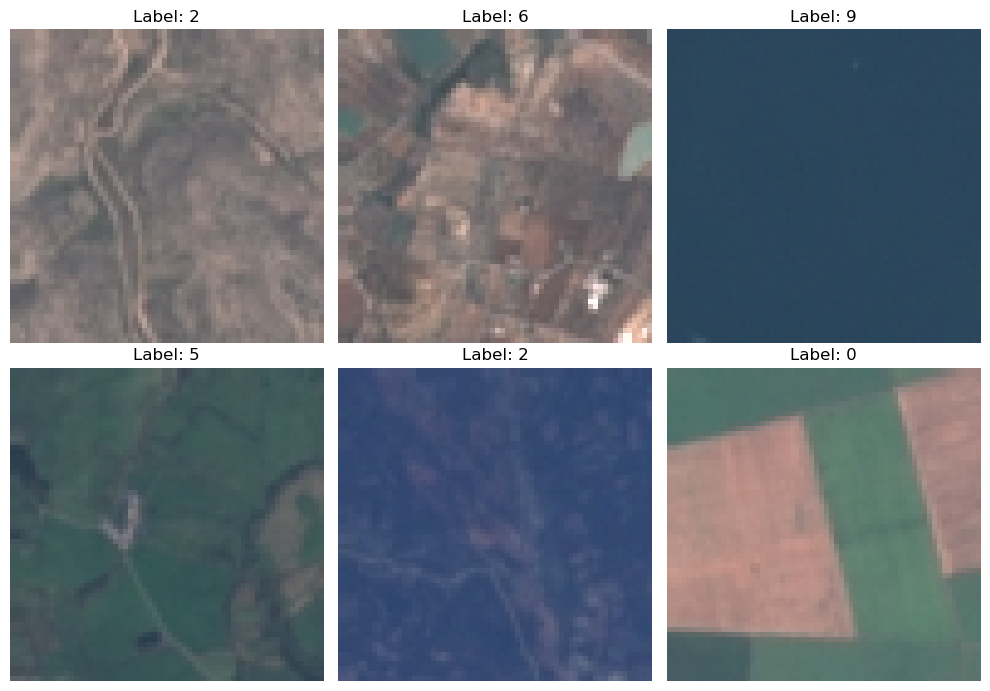

In [8]:
###
# plot_images_from_loader() :: Used to test the impact of transformations in Q5
####
def plot_images_from_loader(loader):
    # Get a batch of images and labels
    images, labels = next(iter(loader))
    
    # Set up a 2x3 subplot
    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    
    # Loop through the first 6 images
    for i, ax in enumerate(axes.flat):
        # Convert tensor image to numpy array and adjust for matplotlib
        img = images[i].numpy().transpose(1, 2, 0)
        
        # Plot the image
        ax.imshow(img)
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()
    

    
    
plot_images_from_loader(train_loader)


In [9]:
# RUN TRAINING
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=n_epochs, scheduler=scheduler)


Epoch: 1 
	Training Loss: 1.859062 	Validation Loss: 1.598557 
	Training Accuracy: 28.47% 	Validation Accuracy: 37.75%
Validation loss decreased (inf --> 1.598557). Saving model ...

Epoch: 2 
	Training Loss: 1.569198 	Validation Loss: 1.597449 
	Training Accuracy: 42.75% 	Validation Accuracy: 40.65%
Validation loss decreased (1.598557 --> 1.597449). Saving model ...

Epoch: 3 
	Training Loss: 1.336907 	Validation Loss: 1.193296 
	Training Accuracy: 52.21% 	Validation Accuracy: 57.50%
Validation loss decreased (1.597449 --> 1.193296). Saving model ...

Epoch: 4 
	Training Loss: 1.087360 	Validation Loss: 1.064664 
	Training Accuracy: 61.69% 	Validation Accuracy: 60.14%
Validation loss decreased (1.193296 --> 1.064664). Saving model ...

Epoch: 5 
	Training Loss: 0.928651 	Validation Loss: 0.999001 
	Training Accuracy: 67.12% 	Validation Accuracy: 63.87%
Validation loss decreased (1.064664 --> 0.999001). Saving model ...

Epoch: 6 
	Training Loss: 0.813743 	Validation Loss: 0.850641 
	

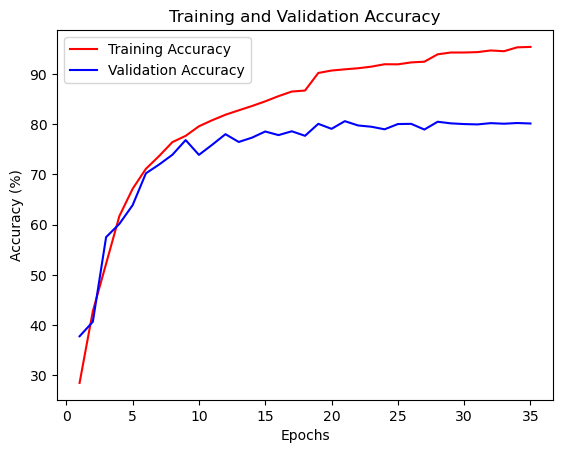

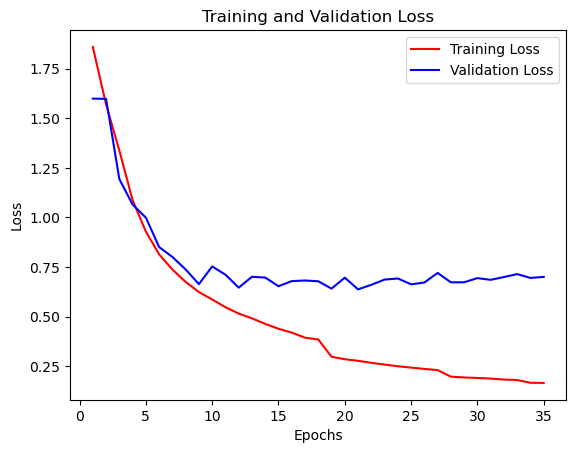

In [10]:
########################################################
# plot_accuracy() :: training and validation accuracy  #
########################################################
def plot_accuracy(train_accuracies, valid_accuracies):
    epochs = range(1, len(train_accuracies) + 1)  # defined like this for the event of early stopping
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

################################################
# plot_loss() :: training and validation loss  #
################################################
def plot_loss(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)  
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Plot accuracy and loss
plot_accuracy(train_accuracies, valid_accuracies)
plot_loss(train_losses, valid_losses)

To avoid overfitting, an early stop criteria has been applied. 
Nevertheless, a very loose early stop condition has been used to show how fast the SimpleCNN() starts overfiting. 

We use the test sample (which has not been seen by the training at any point) to evaluate the models performance.

In [11]:
####################################################################################
# test_model() :: Evaluates the performance of the model on the given test_loader  #
####################################################################################
def test_model(model, test_loader, criterion):
    # Load the weights of the model to test
    #model.load_state_dict(torch.load('./Model/Simple-CNN/model.pth'))
    
    # Set the model to evaluation mode
    model.eval()
    
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    # Turn off gradients for test evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            # Forward pass: compute predictions
            output = model(images)
            
            # Calculate the test loss
            loss = criterion(output, labels)
            test_loss += loss.item() * images.size(0)  # Accumulate the test loss
            
            # Calculate accuracy
            _, predicted = torch.max(output, 1)  # Get predicted class
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    
    # Calculate average test loss
    test_loss = test_loss / len(test_loader.sampler)
    
    # Calculate test accuracy
    test_accuracy = 100 * correct_test / total_test
    
    print(f'\nTest Loss: {test_loss:.6f} \nTest Accuracy: {test_accuracy:.2f}%')

In [12]:
test_model(model, test_loader, criterion)


Test Loss: 0.646451 
Test Accuracy: 80.54%


**Q5:** Your role as a researcher is to improve the performance of the current neural network. Explain the architecture that provided the best performance and describe the modifications that you think provided the gain.
    

### 5.1 Data augmentation
First, I would add data augmentation in the dataset pipeline to make the model more robust.

To do so we use transformations.
 -  RandomHorizontalFlip(p=0.5): Flips the image horizontally with a probability of 50%.
 -  RandomVerticalFlip(p=0.5): Sane vertically
 -  RandomRotation(20): Applies a random rotation to the image within a range of ±10 degrees. This helps the model become more invariant to small rotations in the input images, improving robustness.
 
The we redefine the old DataLoaderClassification() so that it works with transformation.
Then, in the training stage, the transformations are used to augment the data.
Note that we are not augmenting the size of the dataset explicitally, the data is augmented (applying random transforamtions to the images) on the fly during each epoch.

In [13]:
from PIL import Image
# Data transformation with augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(64, 64), antialias=True),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225])
    # use transform uniform
])


########################################################
#  DataLoaderClassification_improved ::                #
########################################################
class DataLoaderClassification_improved(Dataset):
    def __init__(self, data_dir, file_list_path, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        label_set = set()
        
        with open(file_list_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    updated_path = line.replace('EuroSAT/', '')
                    self.image_paths.append(updated_path)
                    
                    label = os.path.split(updated_path)[0].replace('./Data/', '')
                    self.labels.append(label)
                    label_set.add(label)
                    
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(label_set))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_full_path = self.image_paths[idx]
        label = self.labels[idx]

        image = cv2.imread(img_full_path)
        if image is None:
            raise FileNotFoundError(f"Image at path {img_full_path} could not be loaded.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transform if provided
        if self.transform:
            image = Image.fromarray(image)  # Convert image to PIL Image for compatibility with torchvision.transforms
            image = self.transform(image)

        else:
            # Default: Convert to tensor if no transform is provided
            transform = transforms.ToTensor()
            image = transform(image)

        
        label = self.label_to_index[label]
        label = torch.tensor(label)
        
        return image, label
    
train_dataset_new = DataLoaderClassification_improved(data_dir=data_dir, file_list_path=train_file_list, transform=transform)
test_dataset_new = DataLoaderClassification_improved(data_dir=data_dir, file_list_path=test_file_list, transform=None)

print(f"Number of items in train_dataset_new: {len(train_dataset_new)}")
print(f"Number of items in test_dataset_new: {len(test_dataset_new)}")


print("\nSplit the train in train + validation")
# split train in validation + train
train_sampler_new = SubsetRandomSampler(train_idx)
valid_sampler_new = SubsetRandomSampler(valid_idx)

# Load data en batches
batch_size = 20

train_loader_new = DataLoader(train_dataset_new, batch_size=batch_size, sampler=train_sampler_new)
valid_loader_new = DataLoader(train_dataset_new, batch_size=batch_size, sampler=valid_sampler_new)
test_loader_new = DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False)

if Debug:
    print(f"\n  Samples in train_loader: {len(train_loader.sampler)}")
    print(f"  Batches in train_loader: {len(train_loader)}")

    print(f"\n  Samples in valid_loader: {len(valid_loader.sampler)}")
    print(f"  Batches in valid_loader: {len(valid_loader)}")

    print(f"\n  Samples in test_loader: {len(test_loader.dataset)}")
    print(f"  Batches in test_loader: {len(test_loader)}")
    

print_batches(train_loader_new,"Train", Debug=False)
print_batches(valid_loader_new,"Validation", Debug=False)
print_batches(test_loader_new,"Test", Debug=False)


Number of items in train_dataset_new: 21600
Number of items in test_dataset_new: 5400

Split the train in train + validation

  Samples in train_loader: 17280
  Batches in train_loader: 864

  Samples in valid_loader: 4320
  Batches in valid_loader: 216

  Samples in test_loader: 5400
  Batches in test_loader: 270


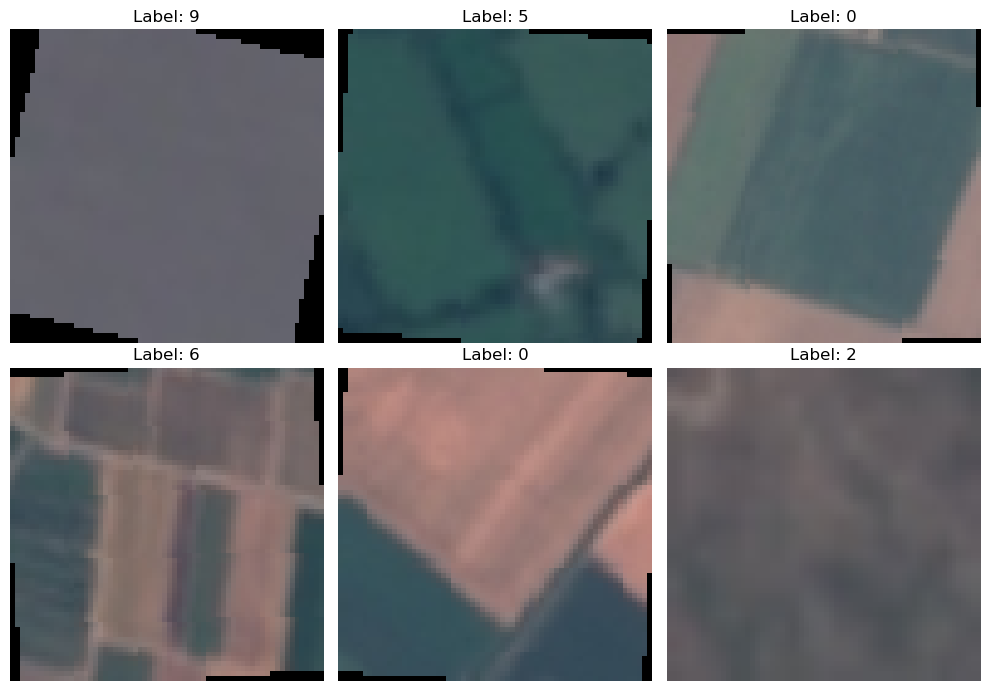

In [14]:
# Debuggger :: Visualize the images that come into the training
plot_images_from_loader(train_loader_new)

Observe the effect of random rotations and flips.

Let's train the same SimpleCNN model but this time we will be using the data augmentation.

In [15]:
model_new = SimpleCNN()
#print(model)
n_epochs = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_new.parameters(), lr=0.01)
#optimizer = optim.Adam(model_new.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

###############################################
# initialize_weights() :: initialize the weights of nn.Conv2d and nn.Linear
#                         using Xavier initialization.
###############################################
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

#model_new.apply(initialize_weights)
model_new.to(device)

 
    
train_losses_new, valid_losses_new, train_accuracies_new, valid_accuracies_new = train_model(
    model_new, train_loader_new, valid_loader_new, 
    criterion, optimizer, num_epochs=n_epochs, scheduler=scheduler,
    patience=40, threshold=0.05, 
    save_path="./Model/Simple-CNN/", save_name="model_with_augmented_data.pth"
)




Epoch: 1 
	Training Loss: 1.878199 	Validation Loss: 1.698865 
	Training Accuracy: 27.32% 	Validation Accuracy: 35.86%
Validation loss decreased (inf --> 1.698865). Saving model ...

Epoch: 2 
	Training Loss: 1.602538 	Validation Loss: 1.422169 
	Training Accuracy: 40.97% 	Validation Accuracy: 49.38%
Validation loss decreased (1.698865 --> 1.422169). Saving model ...

Epoch: 3 
	Training Loss: 1.392056 	Validation Loss: 1.347228 
	Training Accuracy: 50.58% 	Validation Accuracy: 51.37%
Validation loss decreased (1.422169 --> 1.347228). Saving model ...

Epoch: 4 
	Training Loss: 1.251989 	Validation Loss: 1.209519 
	Training Accuracy: 55.92% 	Validation Accuracy: 57.04%
Validation loss decreased (1.347228 --> 1.209519). Saving model ...

Epoch: 5 
	Training Loss: 1.162299 	Validation Loss: 1.045417 
	Training Accuracy: 58.78% 	Validation Accuracy: 63.91%
Validation loss decreased (1.209519 --> 1.045417). Saving model ...

Epoch: 6 
	Training Loss: 1.095175 	Validation Loss: 2.001764 
	

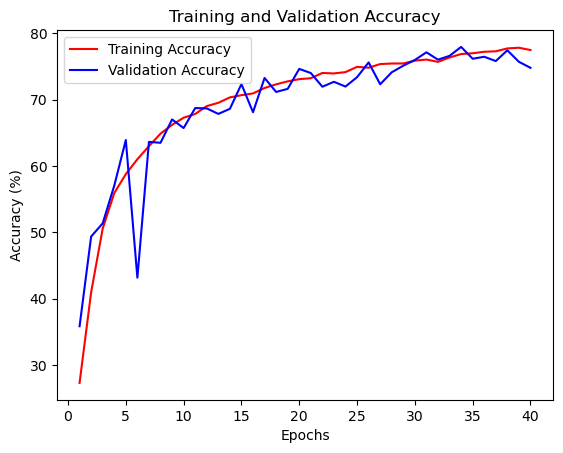

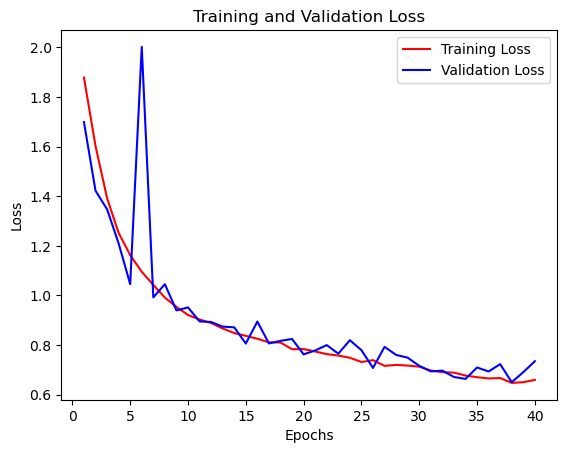

In [16]:
plot_accuracy(train_accuracies_new, valid_accuracies_new)
plot_loss(train_losses_new, valid_losses_new)

In [17]:
test_model(model_new, test_loader_new, criterion)


Test Loss: 0.776371 
Test Accuracy: 73.76%


It is indeed surprising that applying data augmentation to SimpleCNN() led to worse performance, but this can happen for several reasons. One possibility could be inappropriate augmentations. However, in this case, the flips and crops should be appropiate, as satellite images generally don't have specific orientations. In principle, horizontal flips and crops make sense for such data.

A potential solution to the issue could be to use less aggressive transformations, such as applying smaller rotation angles or reducing the probability of flips. This would still introduce variability into the training data without distorting the important features.

Nevertheless, it is important to note that the training of the model with data augmentation led to less overfitting compared to the original training. Even though the performance on the test set was slightly lower, the model trained with augmented data is likely more robust and generalized, as data augmentation often helps models generalize better by preventing them from relying too heavily on specific patterns in the training data.

### 5.2 Define the improved CNN

Now we improve the architecture of the Simple CNN by increasing the depth and complexity of the network. First, we add batch normalization (bn1, bn2, bn3, and bn4) after each of the convolutional layers (conv1, conv2, conv3, and conv4). Batch normalization normalizes the output of each layer to have zero mean and unit variance across the batch, which helps stabilize the learning process and makes the network less sensitive to weight initialization. Placing batch normalization after the convolution layers ensures that the activations fed into the next layer are properly scaled and normalized.


Additionally, we increase the number of convolutional layers from two to four, allowing the network to capture more complex and hierarchical features from the input images. We also increase the number of filters in each convolutional layer (32, 64, 128, 256), progressively extracting more detailed features as the network deepens. Using 3x3 kernels with padding ensures that the spatial dimensions of the feature maps are preserved after each convolution, while max pooling reduces the spatial size, allowing for translation invariance and computational efficiency.


We introduce global average pooling before the fully connected layers, replacing the flattening operation. Global average pooling reduces each feature map to a single value, which drastically reduces the number of parameters and improves generalization by preventing overfitting. It also allows the network to handle varying input sizes better.



Then, a dropout layer is added before the final output layer. Dropout is used to prevent overfitting by randomly "dropping out" (i.e., ignoring) a subset of the neurons during each forward pass, effectively forcing the model to learn redundant representations. Dropout is typically applied to fully connected layers as these layers often have the most parameters, making them more prone to overfitting.

In [18]:
###############################################
#  impoved_CNN() :: defined form SimpleCNN    #
###############################################
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 3x3 kernel, padding to preserve size
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Increase number of filters
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fourth Convolutional Layer (Optional)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Global Average Pooling (instead of Flatten)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Creates a 1x1 image with many channels

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)  # Match input to output channels of the last conv layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Final output for 10 classes

        # Dropout Layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # First Convolutional Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Reduce size by half

        # Second Convolutional Block
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Third Convolutional Block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Fourth Convolutional Block (Optional)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Global Average Pooling
        x = self.global_avg_pool(x)  # Reduces to (batch_size, 256, 1, 1) # 256 = number of channels
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout for regularization
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer
        
        return x
    
    
model = ImprovedCNN()
print(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
n_epochs = 100

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
train_losses_imp, valid_losses_imp, train_accuracies_imp, valid_accuracies_imp = train_model(
    model, train_loader_new, valid_loader_new,  
    criterion, optimizer, num_epochs=n_epochs, 
    scheduler=scheduler, patience=100, threshold=0.01, 
    save_path="./Model/Improved-CNN/", save_name="model_01.pth"
)




Epoch: 1 
	Training Loss: 1.538475 	Validation Loss: 1.061872 
	Training Accuracy: 45.25% 	Validation Accuracy: 61.23%
Validation loss decreased (inf --> 1.061872). Saving model ...

Epoch: 2 
	Training Loss: 1.203217 	Validation Loss: 1.006088 
	Training Accuracy: 59.23% 	Validation Accuracy: 63.70%
Validation loss decreased (1.061872 --> 1.006088). Saving model ...

Epoch: 3 
	Training Loss: 1.099020 	Validation Loss: 1.121946 
	Training Accuracy: 62.28% 	Validation Accuracy: 59.70%

Epoch: 4 
	Training Loss: 1.038825 	Validation Loss: 1.032342 
	Training Accuracy: 65.08% 	Validation Accuracy: 63.36%

Epoch: 5 
	Training Loss: 0.986124 	Validation Loss: 0.795283 
	Training Accuracy: 66.58% 	Validation Accuracy: 73.40%
Validation loss decreased (1.006088 --> 0.795283). Saving model ...

Epoch: 6 
	Training Loss: 0.949936 	Validation Loss: 0.731722 
	Training Accuracy: 68.19% 	Validation Accuracy: 74.86%
Validation loss decreased (0.795283 --> 0.731722). Saving model ...

Epoch: 7 
	T


Epoch: 58 
	Training Loss: 0.407023 	Validation Loss: 0.297041 
	Training Accuracy: 87.73% 	Validation Accuracy: 90.28%

Epoch: 59 
	Training Loss: 0.415831 	Validation Loss: 0.314221 
	Training Accuracy: 87.89% 	Validation Accuracy: 89.81%

Epoch: 60 
	Training Loss: 0.409430 	Validation Loss: 0.311977 
	Training Accuracy: 87.70% 	Validation Accuracy: 89.84%

Epoch: 61 
	Training Loss: 0.407384 	Validation Loss: 0.298882 
	Training Accuracy: 87.65% 	Validation Accuracy: 90.16%

Epoch: 62 
	Training Loss: 0.415187 	Validation Loss: 0.301455 
	Training Accuracy: 87.68% 	Validation Accuracy: 90.16%

Epoch: 63 
	Training Loss: 0.409446 	Validation Loss: 0.316103 
	Training Accuracy: 87.96% 	Validation Accuracy: 89.38%

Epoch: 64 
	Training Loss: 0.409369 	Validation Loss: 0.301956 
	Training Accuracy: 87.92% 	Validation Accuracy: 90.05%

Epoch: 65 
	Training Loss: 0.405562 	Validation Loss: 0.298090 
	Training Accuracy: 87.88% 	Validation Accuracy: 89.98%

Epoch: 66 
	Training Loss: 0.41

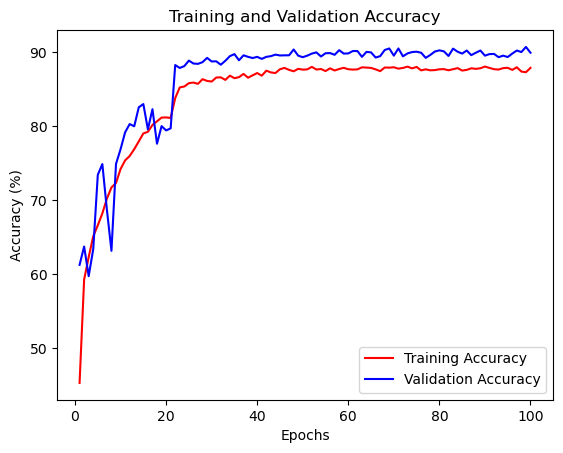

In [20]:
plot_accuracy(train_accuracies_imp, valid_accuracies_imp)

As expected, the training accuracy increases steadily throughout the training process, reaching arround 88%.
There is a slow but consistent improvement, indicating that the model is continuing to learn, but it seems to have saturated after 30 epochs.

The validation accuracy increases rapidly in the early epochs, which is good. Interestingly, the validation accuracy is higher than the training accuracy from early on (around epoch 10 onwards), which is unusual. 
After about 20 epochs, validation accuracy stabilizes around 90% with minor oscillations.

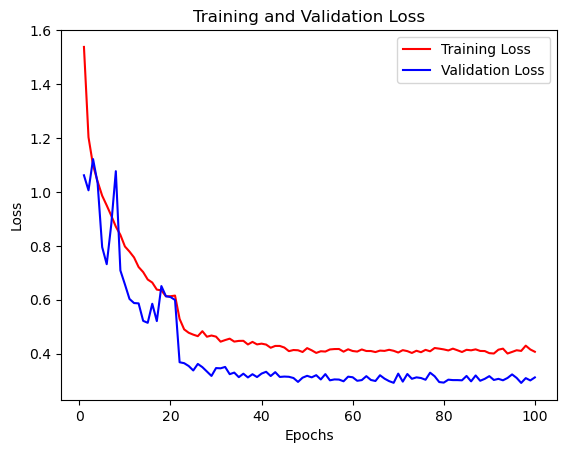

In [21]:
plot_loss(train_losses_imp, valid_losses_imp)

During the first 30 epochs, he training loss decreases consistently over time, as expected, which indicates that the model is minimizing the error on the training set. Afterwards the performance of the model stops improving.

The validation loss decreases rapidly at first but shows a few spikes early on before stabilizing. This behavior is not unusual in the early stages of training.
From around 20 epochs onward, the validation loss stabilizes, with minor fluctuations, suggesting that the model has learned the general patterns in the data without overfitting too much. 

In [22]:
test_model(model, test_loader_new, criterion)


Test Loss: 0.199294 
Test Accuracy: 93.70%


The new ImprovedCNN() model significantly outperforms the older SimpleCNN() model, with a reduction in **test loss** from 0.646 to 0.199, and a substantial **increase in test accuracy** from 80.54% to 93.70%. This shows that the ImprovedCNN() is not only making more accurate predictions but is also generalizing much better on unseen test data.


The architectural enhancements in ImprovedCNN() contributed to the performance boost:
-   **More convolutional layers** (4 layers in ImprovedCNN vs. 2 layers in SimpleCNN) allow the model to extract more complex features from the satellite images.
-   **Batch normalization** helps stabilize training and improves convergence speed by normalizing the activations at each layer.
-   **Dropout layers** prevent overfitting by randomly deactivating a fraction of neurons during training.
-   **Global average pooling** replaces the flattening operation, reducing the number of parameters and improving generalization.

This comparison shows that thoughtful architectural improvements can lead to **significant gains** in model performance, helping to extract richer features and avoid overfitting, ultimately achieving better accuracy on the test set.